<a href="https://colab.research.google.com/github/lsteffenel/RT0902-IntroML/blob/main/15-Chicago_crime_data_on_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chicago crime dataset analysis
---

Ce notebook permet d'appliquer un peu de vos connaissances à la découverte d'un vrai dataset.

Vous allez effectuer :
 * Lecture, transformation et requêtage avec Apache Spark
 * Visualisation avec des bibliothèques Python (Matplotlib et Seaborn).
 * Parfois, transformer les données en Pandas ou Numpy pour une meilleure visualisation.


---

## Quelques Import



Standard python data analysis imports

In [1]:
## standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Spark imports

In [2]:
import os
memory = '8g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [3]:
## spark imports
from pyspark.sql import Row, SparkSession
import pyspark.sql.functions as pyf

spark = SparkSession.builder.master("local[1]").appName("RT0902").getOrCreate()

Jupyter visualization options

In [ ]:
%matplotlib inline

#Not too sure the following 2 work. This is a TODO
sns.set_color_codes("pastel")
plt.rcParams["figure.figsize"] = [20, 8]

---
## Dataset
Les données originales viennent de Kaggle (https://www.kaggle.com/djonafegnem/chicago-crime-data-analysis)

On trouve une liste de crimes registrés par le département de police de Chicago.

Le dataset "réel" contient 4 fichiers pour des crimes allant de 2001 à 2017.
Comme le traitement de ces fichiers est long et demandeur en ressources, vous allez d'abord travailler avec un fichier réduit, qui ne contient que des données de 2001.

Une fois votre code "validé", vous pouvez l'utiliser sur le cloud pour traiter l'ensemble de fichiers de la police.

Ci-dessous vous trovez une description des différents champs des fichiers

In [4]:
content_cols = '''
ID - Unique identifier for the record.
Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
Date - Date when the incident occurred. this is sometimes a best estimate.
Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.
IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
Primary Type - The primary description of the IUCR code.
Description - The secondary description of the IUCR code, a subcategory of the primary description.
Location Description - Description of the location where the incident occurred.
Arrest - Indicates whether an arrest was made.
Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Y Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
Year - Year the incident occurred.
Updated On - Date and time the record was last updated.
Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.'''

In [5]:
def entry_dic(line):
    """
    Convert a header - description line into a single dictionary that holds the original header as 'title', a corresponding field name as 'header', and a description.
    """
    pair = line.split(' - ')
    return {'title': pair[0], 'description': pair[1], 'header': pair[0].lower().replace(' ', '_')}

Créer une liste de titres à partir de la fonction précédente

In [6]:
header_dics = list(map(entry_dic, list(filter(lambda l: l != '', content_cols.split('\n')))))

In [7]:
header_dics[:2]

[{'title': 'ID',
  'description': 'Unique identifier for the record.',
  'header': 'id'},
 {'title': 'Case Number',
  'description': 'The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.',
  'header': 'case_number'}]

### Données

Les données seront téléchargées et stockées dans `./data/`. Ce sont des fichiers .CSV.


In [8]:
!mkdir data

In [9]:
!gsutil -m cp -r gs://angelo_crime_data/*.csv ./data

Copying gs://angelo_crime_data/Chicago_Crimes_2008_to_2011.csv...
Copying gs://angelo_crime_data/Chicago_Crimes_2012_to_2017.csv...
Copying gs://angelo_crime_data/mini_data.csv...
Copying gs://angelo_crime_data/Chicago_Crimes_2001_to_2004.csv...
Copying gs://angelo_crime_data/Chicago_Crimes_2005_to_2007.csv...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [5/5 files][  2.0 GiB/  2.0 GiB] 100% Done  54.0 MiB/s ETA 00:00:00           
Operation completed over 5 objects/2.0 GiB.                                      


In [10]:
!ls -lh data/

total 2.0G
-rw-r--r-- 1 root root 454M Mar  8 18:16 Chicago_Crimes_2001_to_2004.csv
-rw-r--r-- 1 root root 450M Mar  8 18:16 Chicago_Crimes_2005_to_2007.csv
-rw-r--r-- 1 root root 647M Mar  8 18:16 Chicago_Crimes_2008_to_2011.csv
-rw-r--r-- 1 root root 350M Mar  8 18:16 Chicago_Crimes_2012_to_2017.csv
-rw-r--r-- 1 root root 135M Mar  8 18:16 mini_data.csv


---
## Lecture des données

Avec l'opération `csv read` de spark, nous allons lire et parser les fichiers. Le résultat sera un seul DataFrame :

In [22]:
#df = spark.read.csv('./data/Chicago_*.csv', inferSchema=True, header=True)
df = spark.read.csv('./data/mini_data.csv', inferSchema=True, header=True)

Note : ce qui prend vraiment le temps est la découverte du schéma : on n'a pas tellement de lignes, après tout.

In [23]:
# Ce DataFrame sera mis en cache (gardé en mémoire) car il sera utilisé plusieurs fois.
df = df.cache()

In [24]:
# Affichage du schéma (structure) du dataframe
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- case_number: string (nullable = true)
 |-- date: string (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- beat: integer (nullable = true)
 |-- district: double (nullable = true)
 |-- ward: double (nullable = true)
 |-- community_area: double (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: double (nullable = true)
 |-- y_coordinate: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- updated_on: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)



### Différences entre Pandas et Spark
Pandas a des opérations telles que `info()` et `describe()`. Dans Spark, on n'a que `describe()`, qui n'est pas comparable à celle de Pandas : il affiche plutôt le type des données, un peu comme `printSchema()`.

In [35]:
df.describe()

DataFrame[summary: string, _c0: string, id: string, case_number: string, date: string, block: string, iucr: string, primary_type: string, description: string, location_description: string, beat: string, district: string, ward: string, community_area: string, fbi_code: string, x_coordinate: string, y_coordinate: string, year: string, updated_on: string, latitude: string, longitude: string, location: string]

Certaines lignes de n'ont aucune valeur déclarée à la colonne `location_description` . C'est le moment de les supprimer.

Votre première *mission* est de filtrer les entrées vides ('') en utilisant la fonction **`Dataset.filter`**.

In [26]:
# à vous de jouer
df = df.filter(df['location_description'] != '')

Un petit aperçu du début du dataframe :

In [27]:
df.show(n=3, truncate=False)

+---+-------+-----------+----------------------+-----------------------+----+--------------------------+-----------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|_c0|id     |case_number|date                  |block                  |iucr|primary_type              |description                  |location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|updated_on            |latitude    |longitude    |location                     |
+---+-------+-----------+----------------------+-----------------------+----+--------------------------+-----------------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------------------+------------+-------------+-----------------------------+
|0  |4791194|HM403711 

In [30]:
print(df.count())

568515


---
## Comprendre les données

### Types de Crime

On veut connaître combien de types de crime (catégories) existent dans le fichier.

In [28]:
# crime types
crime_type_groups = df.groupBy('primary_type').count()

In [29]:
crime_type_counts = crime_type_groups.orderBy('count', ascending=False)

Jusqu'à ici ça a été rapide : Spark fait une exécution *lazy*, i.e., il n'a fait qu'enregistrer les *transformations* à applier. Il attendra pour lancer l'exécution uniquement lorsqu'une *action* est demandée (par exemple, afficher le résultat).

Dans la ligne suivante on demande le nombre total de lignes, mais en fait il va appliquer les modifications, faire le filtrage, etc. Sur un grand dataset, ça peut prendre pas mal de temps (d'où l'intérêt de distribuer le travail entre plusieurs machines).



La commande suivante affiche les 20 types de crime les plus fréquents :

In [36]:
crime_type_counts.show(truncate=False)

+--------------------------+------+
|primary_type              |count |
+--------------------------+------+
|THEFT                     |115887|
|BATTERY                   |108600|
|CRIMINAL DAMAGE           |65050 |
|NARCOTICS                 |59900 |
|ASSAULT                   |36439 |
|OTHER OFFENSE             |35538 |
|MOTOR VEHICLE THEFT       |32082 |
|BURGLARY                  |30218 |
|ROBBERY                   |21504 |
|DECEPTIVE PRACTICE        |17320 |
|CRIMINAL TRESPASS         |15869 |
|PROSTITUTION              |6977  |
|WEAPONS VIOLATION         |5028  |
|PUBLIC PEACE VIOLATION    |3167  |
|OFFENSE INVOLVING CHILDREN|2619  |
|SEX OFFENSE               |2616  |
|CRIM SEXUAL ASSAULT       |2131  |
|LIQUOR LAW VIOLATION      |1861  |
|HOMICIDE                  |1334  |
|ARSON                     |1177  |
+--------------------------+------+
only showing top 20 rows



On peut faire un affichage plus propre (et d'autres opérations) en transformant ce dataframe en Pandas :

``
crime_type_counts.toPandas()
``

In [37]:
counts_pddf = crime_type_counts.toPandas()

In [38]:
counts_pddf.head(10)

,primary_type,count
0,THEFT,115887
1,BATTERY,108600
2,CRIMINAL DAMAGE,65050
3,NARCOTICS,59900
4,ASSAULT,36439
5,OTHER OFFENSE,35538
6,MOTOR VEHICLE THEFT,32082
7,BURGLARY,30218
8,ROBBERY,21504
9,DECEPTIVE PRACTICE,17320


Ce dataset Pandas peut être utilisé pour une petite visualisation :

[Text(0, 0.5, 'Primary Type'), Text(0.5, 0, 'Crimes Record Count')]

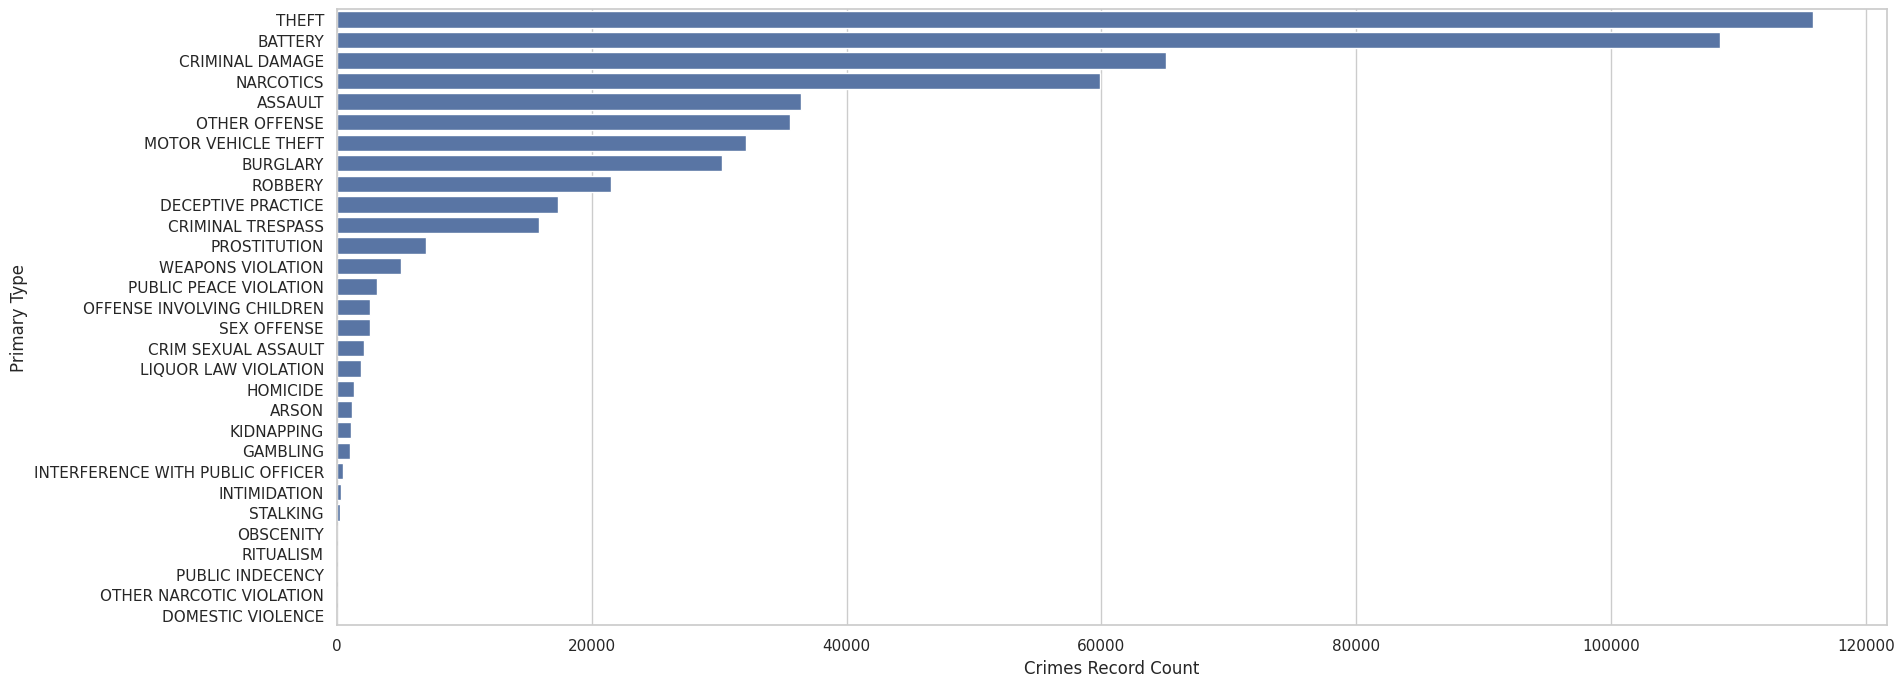

In [39]:
plt.rcParams["figure.figsize"] = [20, 8]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
type_graph = sns.barplot(x='count', y='primary_type', data=counts_pddf)
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

### Période couverte

In [40]:
import datetime
from pyspark.sql.functions import *

In [41]:
df.select(min('date').alias('first_record_date'), max('date').alias('latest_record_date')).show(truncate=False)

+----------------------+----------------------+
|first_record_date     |latest_record_date    |
+----------------------+----------------------+
|01/01/2001 01:00:00 AM|12/31/2001 12:55:00 PM|
+----------------------+----------------------+



Ici, on voir que les fichiers couvrent la période entre le **2001-01-01** et le **2001-12-31** (normal, on a pris le fichier `mini_data.csv` qui ne contennait que des données de 2001.

Toutefois, **si vous avez été attentif**, vous avez remarqué que les colonnes avec des dates ont été lues comme du texte simple :

In [42]:
df.describe()

DataFrame[summary: string, _c0: string, id: string, case_number: string, date: string, block: string, iucr: string, primary_type: string, description: string, location_description: string, beat: string, district: string, ward: string, community_area: string, fbi_code: string, x_coordinate: string, y_coordinate: string, year: string, updated_on: string, latitude: string, longitude: string, location: string]

---
En effet, le schéma montrait que le champ `date` était de type `string`, ce qui n'est pas très utile.

Nous allons convertir ces dates au format timestamp.

Nous allons changer ce format afin de le lire sous la forme '02/23/2006 09:06:22 PM' , c'est à dire **`'MM/dd/yyyy hh:mm:ss a'`** (format américain).

On va aussi rajouter une colonne `month` qui indique le premier jour du mois, sans l'heure.

In [51]:
# d'abord, on convertit 'date' avec to_timestamp() et on enregistre cette valeur dans 'date_time'
df = df.withColumn('date_time', to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a'))
# ensuite, on crée une colonne 'month' à partir de 'datetime')
df = df.withColumn('month', trunc('date_time', 'month')) #adding a month column to be able to view stats on a monthly basis

In [52]:
df.select(['date','date_time', 'month'])\
  .show(n=20, truncate=False)

+----------------------+-------------------+----------+
|date                  |date_time          |month     |
+----------------------+-------------------+----------+
|01/01/2001 11:00:00 AM|2001-01-01 11:00:00|2001-01-01|
|01/01/2001 12:00:00 AM|2001-01-01 00:00:00|2001-01-01|
|01/01/2001 12:00:00 AM|2001-01-01 00:00:00|2001-01-01|
|06/16/2001 08:00:00 AM|2001-06-16 08:00:00|2001-06-01|
|06/01/2001 08:00:00 AM|2001-06-01 08:00:00|2001-06-01|
|07/25/2001 10:00:00 AM|2001-07-25 10:00:00|2001-07-01|
|06/23/2001 08:00:00 PM|2001-06-23 20:00:00|2001-06-01|
|01/01/2001 12:00:00 AM|2001-01-01 00:00:00|2001-01-01|
|05/01/2001 12:01:00 AM|2001-05-01 00:01:00|2001-05-01|
|10/01/2001 12:01:00 AM|2001-10-01 00:01:00|2001-10-01|
|01/01/2001 12:01:00 AM|2001-01-01 00:01:00|2001-01-01|
|10/01/2001 08:00:00 AM|2001-10-01 08:00:00|2001-10-01|
|11/09/2001 09:00:00 AM|2001-11-09 09:00:00|2001-11-01|
|05/30/2001 03:00:00 PM|2001-05-30 15:00:00|2001-05-01|
|06/01/2001 12:00:00 PM|2001-06-01 12:00:00|2001

### Combien d'arrestations ?

Pas tous les crimes donnent lieu à des arrestations.
Grâce à `groupBy`, nous allons afficher le nombre d'arrestations par mois (et le nombre de crimes sans arrestations).

In [53]:
# On peut utiliser la colonne month pour affiche les quantités d'arrestations au fil des années, groupées par mois :
type_arrest_date = df.groupBy(['arrest', 'month'])\
                     .count()\
                     .orderBy(['month', 'count'], ascending=[True, False])
print()
type_arrest_date.show(truncate=False)


+------+----------+-----+
|arrest|month     |count|
+------+----------+-----+
|false |2001-01-01|50720|
|true  |2001-01-01|24275|
|false |2001-02-01|44655|
|true  |2001-02-01|21633|
|false |2001-03-01|37706|
|true  |2001-03-01|15413|
|false |2001-04-01|28258|
|true  |2001-04-01|11908|
|false |2001-05-01|29796|
|true  |2001-05-01|12080|
|false |2001-06-01|29854|
|true  |2001-06-01|11969|
|false |2001-07-01|32838|
|true  |2001-07-01|11963|
|false |2001-08-01|31864|
|true  |2001-08-01|12251|
|false |2001-09-01|30162|
|true  |2001-09-01|11440|
|false |2001-10-01|31168|
|true  |2001-10-01|11963|
+------+----------+-----+
only showing top 20 rows



### Comment le nombre d'emprisonnements a évolué sur l'année ?

Pour l'afichage, nous allons encore une fois transformer notre dataset en Pandas. On transforme `type_arrest_date`, puis on utilise matplotlib pour l'affichage.

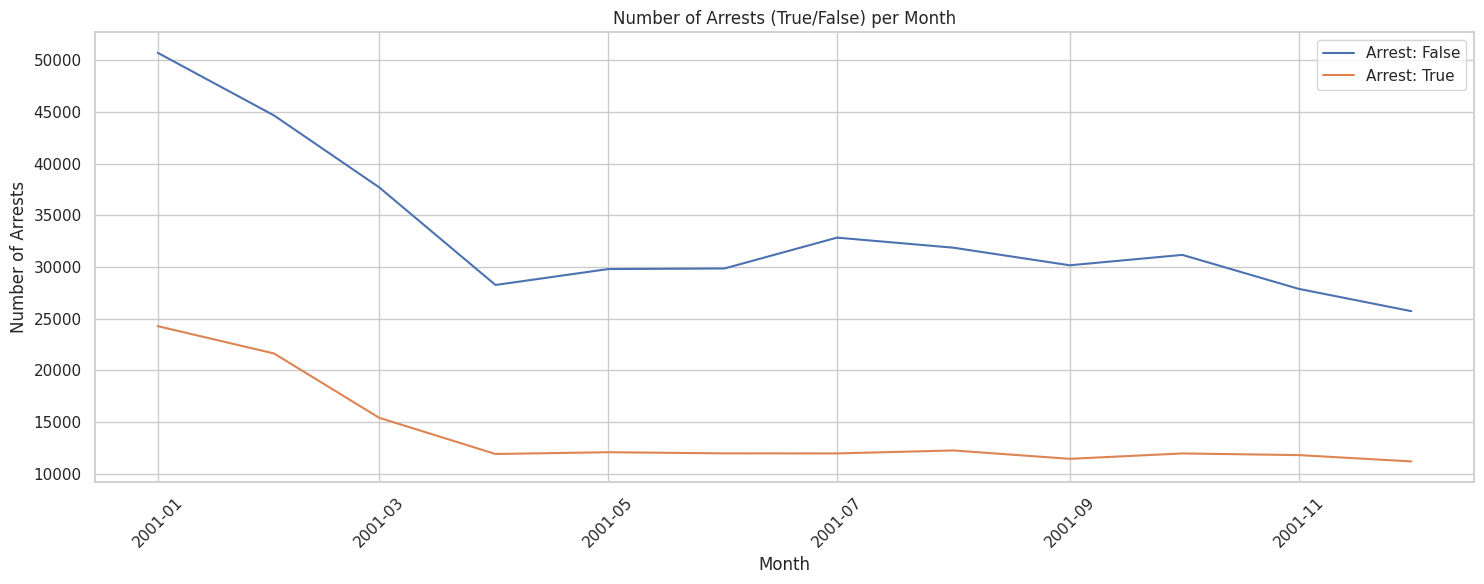

In [64]:
# prompt: à partir de type_arrest_date, générer un graphique matplotlib affichant le nombre arrests true et false, par mois

import matplotlib.pyplot as plt

# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
type_arrest_date_pandas = type_arrest_date.toPandas()

# Create the plot
plt.figure(figsize=(15, 6))
for arrest_status in type_arrest_date_pandas['arrest'].unique():
    subset = type_arrest_date_pandas[type_arrest_date_pandas['arrest'] == arrest_status]
    plt.plot(subset['month'], subset['count'], label=f'Arrest: {arrest_status}')

plt.xlabel('Month')
plt.ylabel('Number of Arrests')
plt.title('Number of Arrests (True/False) per Month')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Mis à part la fin de 2016, la "distance" relative entre arrestations et non-arrestations est plus ou moins constante.

### À quel moment de la journée les criminels sont plus actifs ?

Ici c'est à vous de refaire le même type d'opération. Je vais juste vous montrer comment créer une colonne avec les heures.

In [66]:
# Extract the "hour" field from the date into a separate column called "hour"
df_hour = df.withColumn('hour', hour(df['date_time']))

In [67]:
# Derive a data frame with crime counts per hour of the day:
hourly_count = df_hour.groupBy(['primary_type', 'hour']).count()
hourly_total_count = hourly_count.groupBy('hour').sum('count')

In [72]:
hourly_count_pddf = hourly_count.toPandas()
hourly_total_count_pddf = hourly_total_count.toPandas()

In [74]:
hourly_count_pddf = hourly_count_pddf.sort_values(by='hour')
hourly_total_count_pddf = hourly_total_count_pddf.sort_values(by='hour')

In [79]:
hourly_count_pddf.head(10)

,primary_type,hour,count
320,LIQUOR LAW VIOLATION,0,83
339,NARCOTICS,0,1865
580,MOTOR VEHICLE THEFT,0,2026
151,ARSON,0,109
626,ASSAULT,0,1140
298,HOMICIDE,0,80
46,THEFT,0,5741
292,ROBBERY,0,1207
241,STALKING,0,8
584,WEAPONS VIOLATION,0,311


In [75]:
hourly_total_count_pddf.head(10)

,hour,sum(count)
11,0,28860
5,1,18603
15,2,15247
12,3,12069
19,4,9211
21,5,7368
6,6,7993
23,7,11827
17,8,18115
8,9,22218


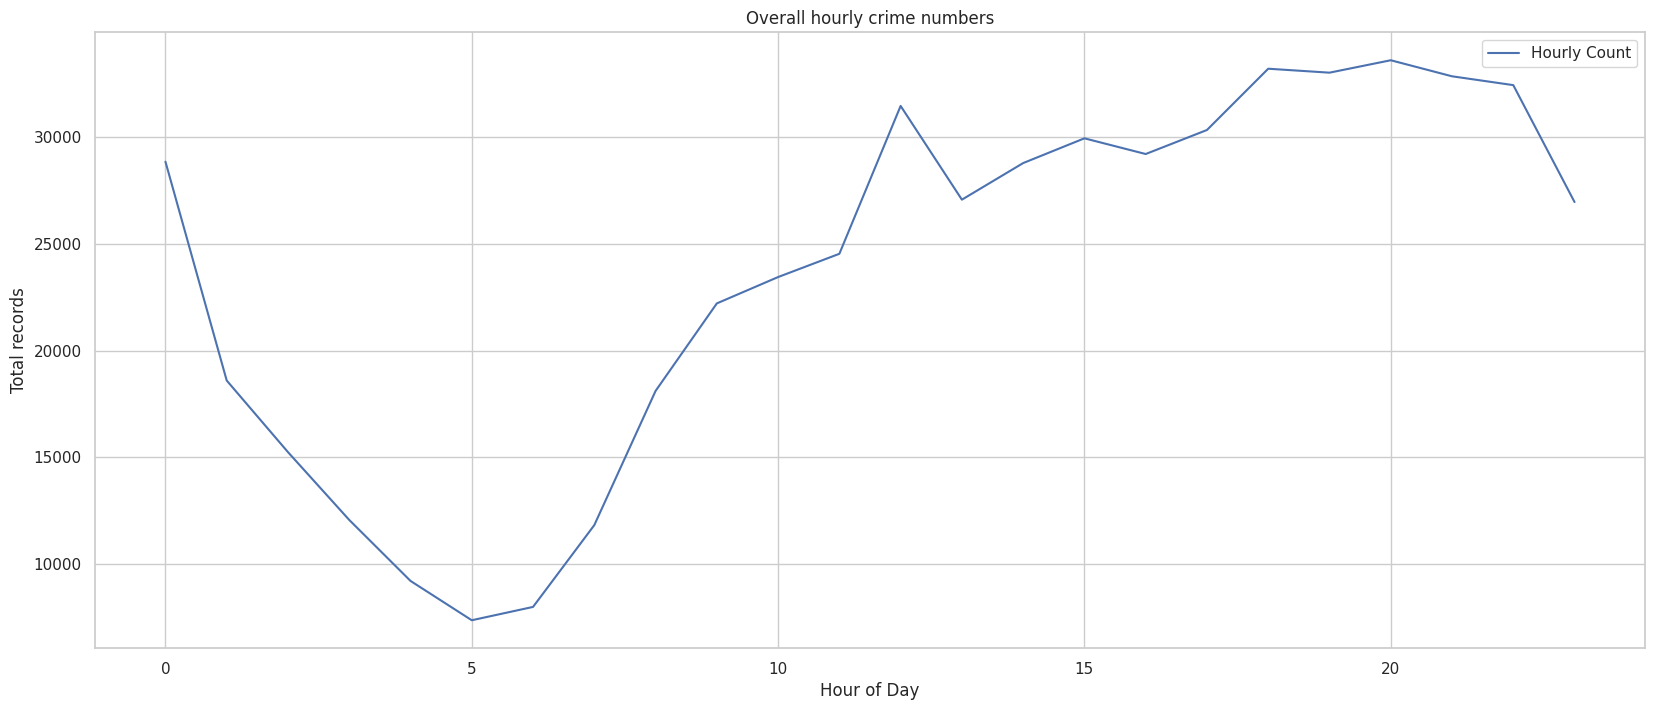

In [77]:
fig, ax = plt.subplots()
ax.plot(hourly_total_count_pddf['hour'], hourly_total_count_pddf['sum(count)'], label='Hourly Count')

ax.set(xlabel='Hour of Day', ylabel='Total records',
       title='Overall hourly crime numbers')
#ax.grid(b=True, which='both', axis='y')
ax.legend()

Il semble que c'est plus agité entre 18h et 22h... avec un pic à midi.

Regardons le détail de chaque type de crime.



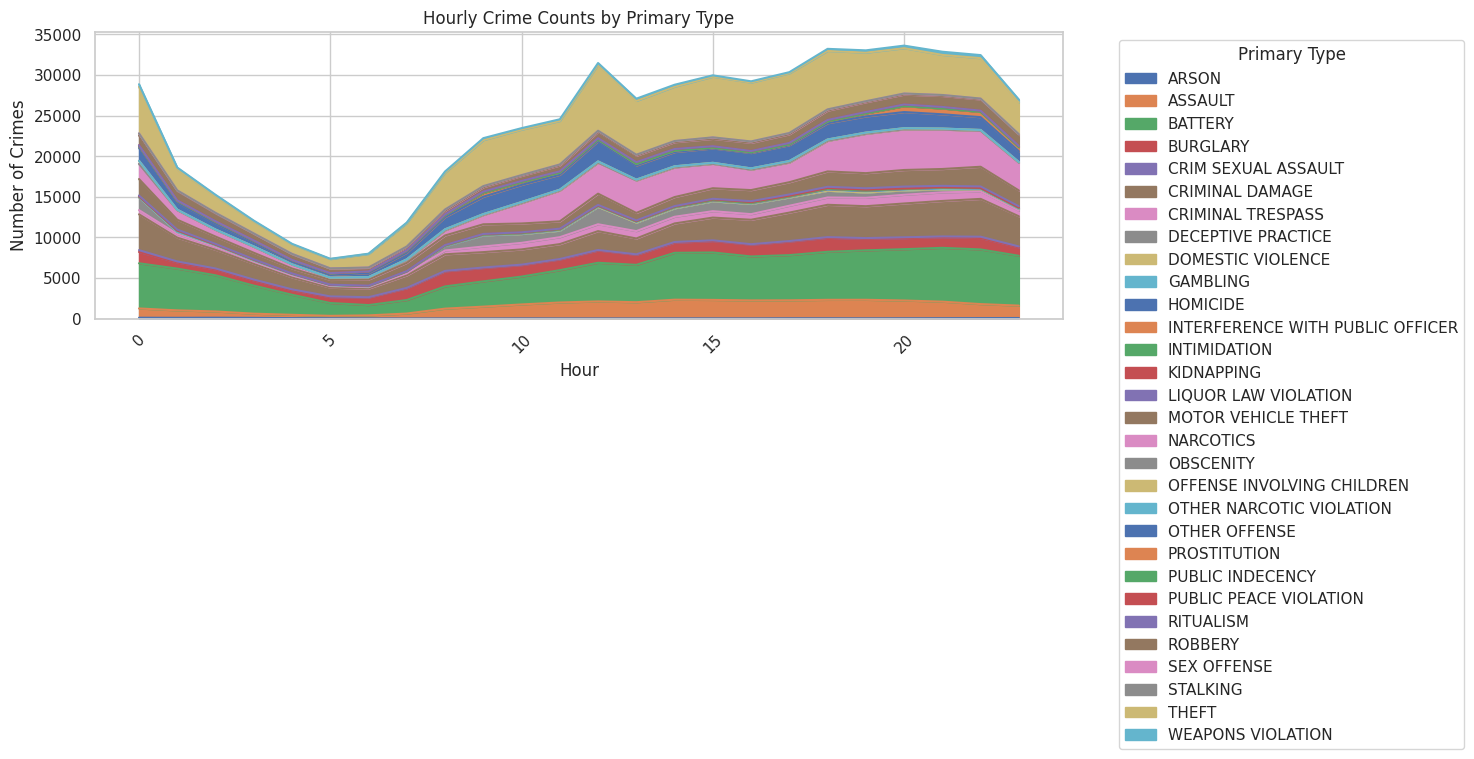

In [82]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(15, 6))

# Group data by hour and primary type and sum the counts
hourly_counts_grouped = hourly_count_pddf.groupby(['hour', 'primary_type'])['count'].sum().unstack()

# Plot stacked area chart
hourly_counts_grouped.plot(kind='area', stacked=True, ax=plt.gca())

plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.title('Hourly Crime Counts by Primary Type')
plt.xticks(rotation=45)
plt.legend(title='Primary Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Dans que type d'endroit les crimes sont commis ?

Le dataset indique la "classe" de lieu où le crime a été commis : maison, rue, etc. Regardons ça en détails.

In [84]:
# Combien de types d'endroit sont recensés
df.select('location_description').distinct().count()

114

Ok, il y a 114 types différents d'endroit qui sont recensés.

Quels sont les 10 endroits les plus fréquents ?

In [85]:
df.groupBy(['location_description']).count().orderBy('count', ascending=False).show(10)

+--------------------+------+
|location_description| count|
+--------------------+------+
|              STREET|175545|
|           RESIDENCE|111318|
|           APARTMENT| 33317|
|            SIDEWALK| 33153|
|               OTHER| 24645|
|PARKING LOT/GARAG...| 18938|
|SCHOOL, PUBLIC, B...| 12615|
|               ALLEY| 12081|
|    RESIDENCE-GARAGE| 11750|
|RESIDENCE PORCH/H...| 10383|
+--------------------+------+
only showing top 10 rows



### Crimes "domestiques" :

En dehors de la localité, le dataset indique aussi s'il s'agit d'une violence domestique (dispute familiale, harcélement, etc.) ou pas.

Regardons ces types de violence plus en détails :

In [96]:
domestic_hour = df_hour.groupBy(['domestic', 'hour']).count().orderBy('hour').toPandas()

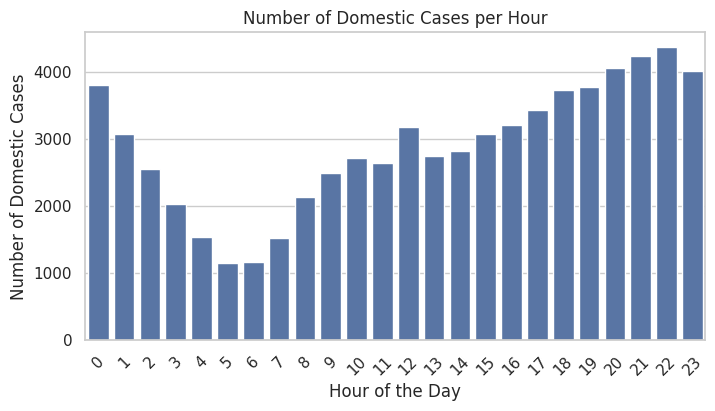

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for domestic cases
domestic_cases = df_hour.filter(df_hour['domestic'] == True)

# Group by hour and count
domestic_cases_by_hour = domestic_cases.groupBy('hour').count().orderBy('hour').toPandas()

# Create the bar plot
plt.figure(figsize=(8, 4))
sns.barplot(x='hour', y='count', data=domestic_cases_by_hour)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Domestic Cases')
plt.title('Number of Domestic Cases per Hour')
plt.xticks(rotation=45)
plt.show()


Il y a une montée des violences domestiques le soir, avec un pic isolé à midi (disputes pendant le repas ?)

Et comment ça se situe par rapport aux crimes/violences "non-domestiques" ?

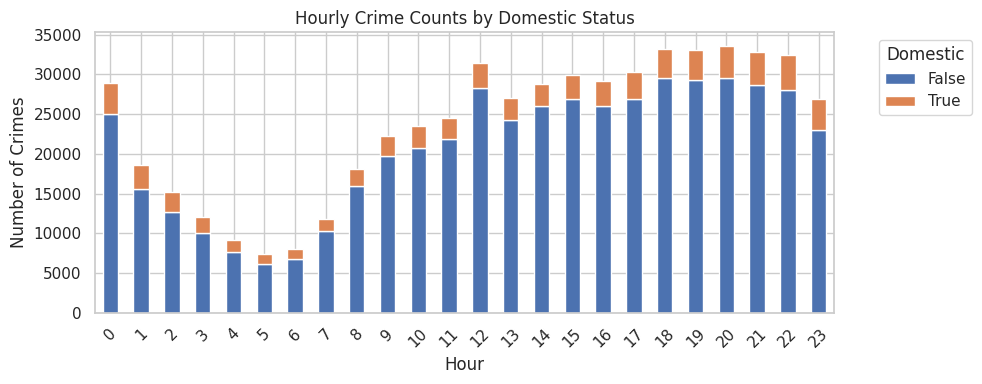

In [100]:
import matplotlib.pyplot as plt
# Create the plot
plt.figure(figsize=(10, 4))

# Group data by hour and domestic status and sum the counts
domestic_counts_grouped = domestic_hour.groupby(['hour', 'domestic'])['count'].sum().unstack()

# Plot stacked bar chart
domestic_counts_grouped.plot(kind='bar', stacked=True, ax=plt.gca())

plt.xlabel('Hour')
plt.ylabel('Number of Crimes')
plt.title('Hourly Crime Counts by Domestic Status')
plt.xticks(rotation=45)
plt.legend(title='Domestic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Une analyse par rapport au temps

Les données de type heure/date permettent d'obtenir plus d'information sur les types de crime et d'émettre des hypothèses sur leurs sursauts. Par ontre, d'autres facteurs externes comme le changement de garde ou les nouvelles politiques de sécurité peuvent avoir un impact non décrit ici.

Néanmoins, si on a une idée de quand et où les crimes sont les plus fréquents, on peut s'aventurer à faire quelques prévisions...

On va rajouter quelques champs utiles :

 * l'heure du jour (déjà présent dans le champ 'hour')
 * le jour de la semaine (dimanche = 1, ..., samedi = 7)
 * le mois de l'année
 * le "numéro du jour" dans une séquence 1, 2...(on commence à compter à partir du 2001-01-01).

In [103]:
df_dates = df_hour.withColumn('week_day', dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', month(df_hour['date_time']))\
                 .withColumn('month_day', dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', datediff(df['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [105]:
df_dates.select(['date', 'month', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(10, truncate=False)

+----------------------+----------+----+--------+----+----------+---------+-----------+
|date                  |month     |hour|week_day|year|year_month|month_day|date_number|
+----------------------+----------+----+--------+----+----------+---------+-----------+
|01/01/2001 11:00:00 AM|2001-01-01|11  |2       |2001|1         |1        |0          |
|01/01/2001 12:00:00 AM|2001-01-01|0   |2       |2001|1         |1        |0          |
|01/01/2001 12:00:00 AM|2001-01-01|0   |2       |2001|1         |1        |0          |
|06/16/2001 08:00:00 AM|2001-06-01|8   |7       |2001|6         |16       |166        |
|06/01/2001 08:00:00 AM|2001-06-01|8   |6       |2001|6         |1        |151        |
|07/25/2001 10:00:00 AM|2001-07-01|10  |4       |2001|7         |25       |205        |
|06/23/2001 08:00:00 PM|2001-06-01|20  |7       |2001|6         |23       |173        |
|01/01/2001 12:00:00 AM|2001-01-01|0   |2       |2001|1         |1        |0          |
|05/01/2001 12:01:00 AM|2001-05-

## Les crimes par rapport au jour de la semaine


In [106]:
week_day_crime_counts = df_dates.groupBy('week_day').count()

In [114]:
week_day_crime_counts_pddf = week_day_crime_counts.orderBy('week_day').toPandas()

<Axes: xlabel='week_day'>

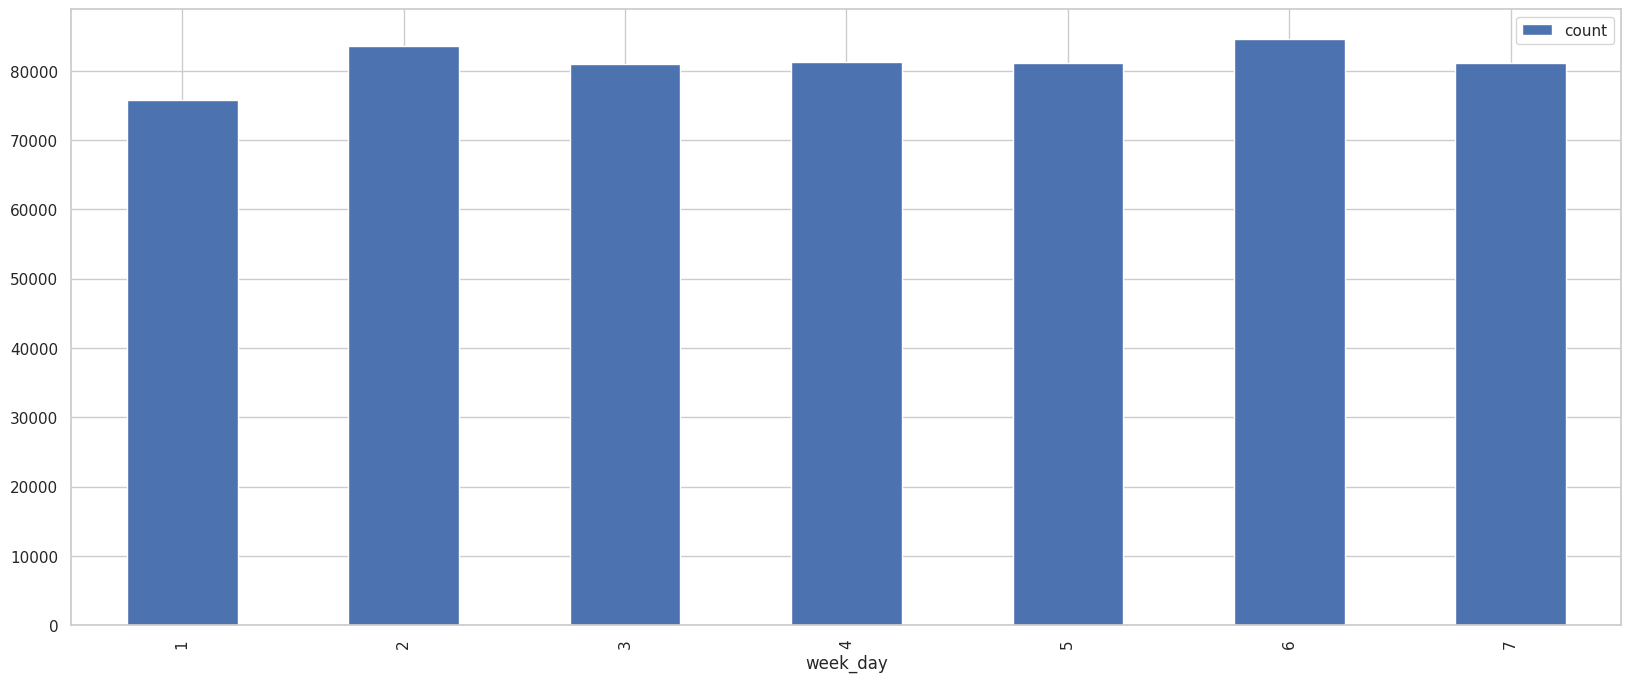

In [115]:
week_day_crime_counts_pddf.plot(kind='bar', x='week_day', y='count')

On voit très peu de variance... D'un autre côté, les criminels restent "méchants" tous les jours. Et probablemnt il y a des crimes le dimanche qui ne sont signalés que le lundi !

## Mois de l'année



In [116]:
year_month_crime_counts = df_dates.groupBy('year_month').count()

In [117]:
year_month_crime_counts_pddf = year_month_crime_counts.orderBy('year_month').toPandas()

Il semble que la période Mai-Août est la plus active pour les criminels. Des idées sur la cause ?


<Axes: xlabel='year_month'>

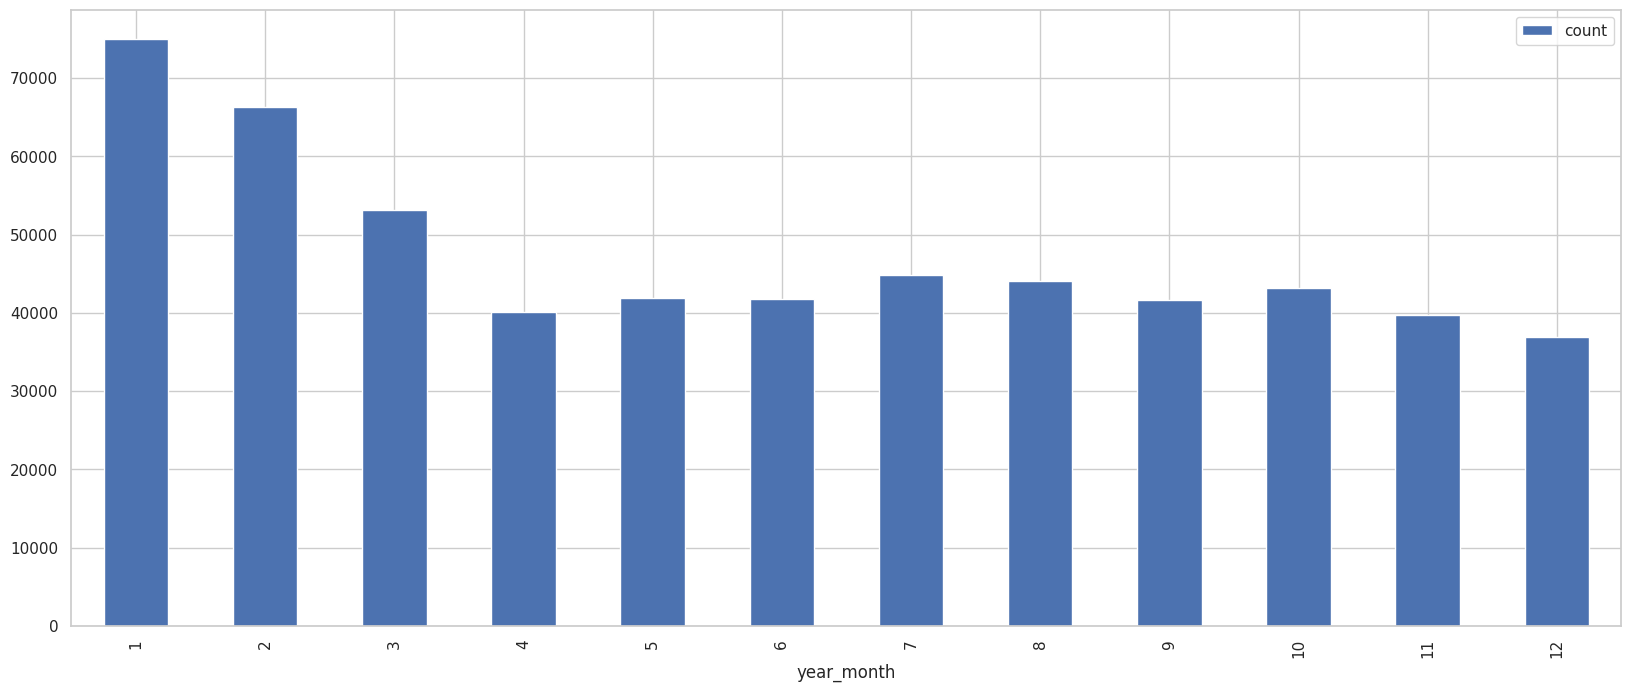

In [118]:
year_month_crime_counts_pddf.plot(y='count', x='year_month', kind='bar')

AH, ça c'est intéressant ! On a beaucoup de crimes en janvier et février. Serait-ça lié à la déprim de l'hiver ? Regardons rapidement si ça a un impact sur les violences domestiques.

In [120]:
domestic_month = df_dates.groupBy(['domestic','year_month']).count().orderBy('year_month').toPandas()

In [126]:
domestic_month.head()

""
0
1
2
3
4


In [123]:
domestic_month = domestic_month.filter(domestic_month['domestic'] == True)

In [125]:
domestic_month.head()

""
0
1
2
3
4


In [124]:
domestic_month.plot(x='year_month', y='count', kind='bar', color='orange')

KeyError: 'year_month'

## Jour du mois

In [ ]:
month_day_crime_counts = df_dates.groupBy('month_day').count()

In [ ]:
month_day_crime_counts_pddf = pd.DataFrame(month_day_crime_counts.orderBy('month_day').rdd.map(lambda e: e.asDict()).collect())

#### Les 10 pire jours du mois

In [ ]:
month_day_crime_counts_pddf.sort_values(by='count', ascending=False).head(10)

In [ ]:
month_day_crime_counts_pddf = month_day_crime_counts_pddf.sort_values(by='month_day', ascending=True)

In [ ]:
fg, ax = plt.subplots()

ax.plot(month_day_crime_counts_pddf['month_day'], month_day_crime_counts_pddf['count'], label='Crimes over the month')

ax.grid(b=True, which='both')
ax.legend()

Que se passe-t-il le 31 de chaque mois ? Est-ce vraiment une baisse ou juste un problème statistique ?

### Et les quartiers ?

Chicago compte 77 quartiers (community areas). Comment le crime est distribuée entre eux ?

In [ ]:
df_dates_community_areas = df_dates.na.drop(subset=['community_area']).groupBy('community_area').count()

Quelles sont les 10 quartiers avec plus de crime ?

In [ ]:
df_dates_community_areas.orderBy('count', ascending=False).show(10)

In [ ]:
## Et quel est le type de crime le plus commun par quartier ?
top_crime_types = df_dates.select('primary_type').groupBy('primary_type').count().rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])
top_busy_areas =  df_dates_community_areas.rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])

In [ ]:
top_crime_types_lst = [dc['primary_type'] for dc in top_crime_types]
top_busy_areas_lst = [dc['community_area'] for dc in top_busy_areas]

In [ ]:
top_crime_types_lst

In [ ]:
top_busy_areas_lst

Afficher les 10 crimes les plus courants, dans les 10 quartiers les plus chauds...

In [ ]:
q1 = "instr('" + ' '.join(top_busy_areas_lst) + "', community_area) > 0"
q2 = "instr('" + ' '.join(top_crime_types_lst) + "', primary_type) > 0"
print(q1)

In [ ]:
## Construct a data frame filtered on these top community areas and top crime types:
df_dates_tops = df_dates.filter(q1).filter(q2)

In [ ]:
df_dates_tops.count()

In [ ]:
tops_of_tops = df_dates_tops.groupBy(['primary_type', 'community_area']).count().orderBy(['primary_type', 'count', 'community_area'], ascending=[True, False, True]).cache()

In [ ]:
tops_of_tops.show(20)

#### Les noms des quartiers

Pour l'instant on avait juste les numéros, on peut croiser cela avec le nom des quartiers.

La source se trouve dans le journal Chicago Tribune  http://www.chicagotribune.com/chi-community-areas-htmlstory.html


In [ ]:
area_names = """
01	Rogers Park
40	Washington Park
02	West Ridge
41	Hyde Park
03	Uptown
42	Woodlawn
04	Lincoln Square
43	South Shore
05	North Center
44	Chatham
06	Lakeview
45	Avalon Park
07	Lincoln Park
46	South Chicago
08	Near North Side
47	Burnside
09	Edison Park
48	Calumet Heights
10	Norwood Park
49	Roseland
11	Jefferson Park
50	Pullman
12	Forest Glen
51	South Deering
13	North Park
52	East Side
14	Albany Park
53	West Pullman
15	Portage Park
54	Riverdale
16	Irving Park
55	Hegewisch
17	Dunning
56	Garfield Ridge
18	Montclare
57	Archer Heights
19	Belmont Cragin
58	Brighton Park
20	Hermosa
59	McKinley Park
21	Avondale
60	Bridgeport
22	Logan Square
61	New City
23	Humboldt Park
62	West Elsdon
24	West Town
63	Gage Park
25	Austin
64	Clearing
26	West Garfield Park
65	West Lawn
27	East Garfield Park
66	Chicago Lawn
28	Near West Side
67	West Englewood
29	North Lawndale
68	Englewood
30	South Lawndale
69	Greater Grand Crossing
31	Lower West Side
70	Ashburn
32	Loop
71	Auburn Gresham
33	Near South Side
72	Beverly
34	Armour Square
73	Washington Heights
35	Douglas
74	Mount Greenwood
36	Oakland
75	Morgan Park
37	Fuller Park
76	O'Hare
38	Grand Boulevard
77	Edgewater
39	Kenwood
"""

In [ ]:
code_pairs = [[float(p[0]), p[1]] for p in [pair.strip().split('\t') for pair in area_names.strip().split('\n')]]

In [ ]:
code_pairs[:5]

#### Une vue de la criminalité par quartier

In [ ]:
community_area_counts = pd.DataFrame(df_dates_community_areas.rdd.map(lambda row: row.asDict()).collect())

In [ ]:
# Create a dictionary of area code to names
area_name_dic = {float(k[0]):k[1] for k in code_pairs}

In [ ]:
community_area_counts['community_area_name'] = community_area_counts['community_area'].apply(lambda area: area_name_dic.get(float(area),  'unknown_%s'%area))

In [ ]:
community_area_counts = community_area_counts.sort_values(by='count')
community_area_counts.head(5)

In [ ]:
plt.rcParams["figure.figsize"] = [32, 32]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

sns.despine(left=True, bottom=True)
area_chart = sns.barplot(x='count', y='community_area_name', data=community_area_counts)
area_chart.set(ylabel="Community Area Name", xlabel="Overall Crimes Record Count")

**Que se passe-t-il dans le quartier Austin ?**

In [ ]:
code_pairs_df = spark.createDataFrame(code_pairs, ['community_area', 'area_name'])

In [ ]:
named_tops_of_tops = code_pairs_df.join(tops_of_tops, on='community_area', how='right')

In [ ]:
named_tops_of_tops.show(10)

In [ ]:
tops_of_tops_dff = pd.DataFrame(named_tops_of_tops.rdd.map(lambda l: l.asDict()).collect() )

In [ ]:
plt.rcParams["figure.figsize"] = [64, 16]
sns.barplot(data=tops_of_tops_dff, x='area_name', y='count', hue='primary_type', palette='pastel')

---


# Pouvons-nous prédire le crime le plus probable à un moment/endroit ?

Afin de le faire, on va nettoyer un peu plus le dataset

### retirer ces variables :

 * 'id' - Random information that isn't a predictor of crime type
 * 'case_number' - Random information that isn't a predictor of crime type
 * 'date' - Removed because it's been re-featurized in other features generated above
 * 'block' - Excluded as this may simply mean noise
 * 'iucr' - Excluded as correlated with crime type. No point.
 * 'x_coordinate' - Not included
 * 'y_coordinate' - Not included
 * 'year' - Not included (already otherwise featurized)
 * 'updated_on' - not included
 * 'latitude' - not included
 * 'longitude' - not included
 * 'location' - not included
 * 'date_time' - Taken into account in other time-related features
 * 'description' - Excluded. I want to see this as associated with the response (primary type)


### Garder ces variables :

 * 'location_description'
 * 'arrest'
 * 'domestic'
 * 'beat'
 * 'district'
 * 'ward'
 * 'community_area'
 * 'fbi_code'
 * 'hour'
 * 'week_day'
 * 'year_month'
 * 'month_day'
 * 'date_number'

In [ ]:
selected_features = [
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area',
 'fbi_code',
 'hour',
 'week_day',
 'year_month',
 'month_day',
 'date_number']

In [ ]:
#Let's see the schema of these selected features:
features_df = df_dates.select(selected_features)
features_df.printSchema()

In [ ]:
feature_level_count_dic = []

for feature in selected_features:
    print('Analysing %s' % feature)
    levels_list_df = features_df.select(feature).distinct()
    feature_level_count_dic.append({'feature': feature, 'level_count': levels_list_df.count()})


In [ ]:
pd.DataFrame(feature_level_count_dic).sort_values(by='level_count', ascending=False)

### Preparer le modèle

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
df_dates_features = df_dates.na.drop(subset=selected_features)



Utilisons le string indexer de Spark pour les variables séléctionnées

In [ ]:
for feature in feature_level_count_dic:
    indexer = StringIndexer(inputCol=feature['feature'], outputCol='%s_indexed' % feature['feature'])
    print('Fitting feature "%s"' % feature['feature'])
    model = indexer.fit(df_dates_features)
    print('Transforming "%s"' % feature['feature'])
    df_dates_features = model.transform(df_dates_features)

Même chose avec les labels

In [ ]:
## String-index the response variable:
response_indexer = StringIndexer(inputCol='primary_type', outputCol='primary_type_indexed')
response_model = response_indexer.fit(df_dates_features)
df_dates_features = response_model.transform(df_dates_features)

In [ ]:
#What does it look like now...
df_dates_features.show(1)


Maintenant, on va vectoriser les éléments pour les avoir dans une colonne `features`

In [ ]:
indexed_features = ['%s_indexed' % fc['feature'] for fc in feature_level_count_dic]
indexed_features

In [ ]:
assembler = VectorAssembler(inputCols=indexed_features, outputCol='features')
vectorized_df_dates = assembler.transform(df_dates_features)

In [ ]:
vectorized_df_dates.select('features').take(1)

### Et entraîner le modèle.

Utiliser une répartition **60%**/**40%** entre les données train et test.

Pour commencer, utilisons une régression logistique.

In [ ]:
train, test = vectorized_df_dates.randomSplit([0.6, 0.4])

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
logisticRegression = LogisticRegression(labelCol='primary_type_indexed', featuresCol='features', maxIter=10, family='multinomial')

In [ ]:
fittedModel = logisticRegression.fit(train)

## Quelle est la performance du modèle ?

In [ ]:
fittedModel.summary.accuracy

In [ ]:
model_summary = fittedModel.summary

In [ ]:
fittedModel.coefficientMatrix

#### Pourquoi nous avons une forme 34x13 ?

Comme on faut une regressions logistique multinomial logistic, elle est entraînée sur **chaque classe** des labels. Ainsi, une probabilité pour chaque classe est identifiée.

In [ ]:
print(fittedModel.coefficientMatrix)

In [ ]:
print('Coefficient matrix:\nRow count = %s\nCol count = %s' % (fittedModel.coefficientMatrix.numRows, fittedModel.coefficientMatrix.numCols))

In [ ]:
print('Model:\nNum Classes = %s\nNum Features = %s' % (fittedModel.numClasses, fittedModel.numFeatures))

In [ ]:
print('Training "primary_type" factor level count = %s' % train.select('primary_type_indexed').distinct().count())

In [ ]:
vectorized_df_dates.select('features').show(2, truncate=False)

In [ ]:
fittedModel.numClasses

In [ ]:
fittedModel.numFeatures

In [ ]:
train.select('primary_type_indexed').distinct().count()

In [ ]:
df_dates.select('primary_type').distinct().count()

In [ ]:
fittedModel.interceptVector.values.size

In [ ]:
print(model_summary.objectiveHistory)
print()
print('Objective history size ', len(model_summary.objectiveHistory))

In [ ]:
sns.barplot(y=model_summary.objectiveHistory, x=list(range(len(model_summary.objectiveHistory))))

In [ ]:
label_stats = {float(i):{'index': float(i)} for i in range(34)}
print(label_stats)

In [ ]:
print("False positive rate by label:")
for i, rate in enumerate(model_summary.falsePositiveRateByLabel):
    label_stats[i]['false_positive_rate'] = rate

for i, rate in enumerate(model_summary.truePositiveRateByLabel):
    label_stats[i]['true_positive_rate'] = rate

for i, rate in enumerate(model_summary.precisionByLabel):
    label_stats[i]['precision_rate'] = rate

for i, rate in enumerate(model_summary.recallByLabel):
    label_stats[i]['recall_rate'] = rate

for i, rate in enumerate(model_summary.fMeasureByLabel()):
    label_stats[i]['f_measure'] = rate

In [ ]:
train_rdd = train.select(['primary_type', 'primary_type_indexed']).distinct().orderBy('primary_type_indexed').rdd.map(lambda l: l.asDict()).collect()


In [ ]:
for l in train_rdd:
    print(l)
    label_stats[l['primary_type_indexed']]['primary_type'] = l['primary_type']

In [ ]:
rates_pddf = pd.DataFrame(list(label_stats.values()))

In [ ]:
rates_pddf = rates_pddf.sort_values(by='precision_rate', ascending=False)

#### Est-ce que ça semble un bon modèle pour prédire les crimes ?

In [ ]:
rates_pddf

## À vous:

 * Exécuter le modèle sur l'ensemble de test